In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
from pprint import pprint
import simplekml
from config import EIA_api_key
from scipy.stats import linregress

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Call the USGS turbine database API

## Add the response to a DataFrame

In [2]:
base_url="https://eersc.usgs.gov/api/uswtdb/v1/turbines"

In [3]:
response = requests.get(base_url).json()

In [4]:
df = pd.DataFrame(response)
df

,case_id,faa_ors,faa_asn,usgs_pr_id,t_state,t_county,t_fips,p_name,p_year,p_tnum,...,t_ttlh,t_conf_atr,t_conf_loc,t_img_date,t_img_srce,xlong,ylat,eia_id,retrofit,retrofit_year
0,3001247,None,None,5115.0,CA,Kern County,6029,251 Wind,1987.0,194,...,NaN,2,3,5/8/2018,Digital Globe,-118.36819,35.07579,52161.0,0,NaN
1,3009410,None,None,5116.0,CA,Kern County,6029,251 Wind,1987.0,194,...,NaN,2,3,5/8/2018,Digital Globe,-118.36809,35.07589,52161.0,0,NaN
2,3072670,None,None,5112.0,CA,Kern County,6029,251 Wind,1987.0,194,...,NaN,2,3,5/8/2018,Digital Globe,-118.36841,35.07554,52161.0,0,NaN
3,3072663,None,None,5114.0,CA,Kern County,6029,251 Wind,1987.0,194,...,NaN,2,3,5/8/2018,Digital Globe,-118.36820,35.07570,52161.0,0,NaN
4,3072661,None,None,5149.0,CA,Kern County,6029,251 Wind,1987.0,194,...,NaN,2,3,5/8/2018,Digital Globe,-118.36376,35.07791,52161.0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68787,3108971,None,2020-WTW-3724-OE,NaN,TX,Zapata County,48505,unknown Zapata County,2021.0,41,...,NaN,1,3,2/6/2021,Digital Globe,-99.29768,27.09550,NaN,0,NaN
68788,3109386,None,2020-WTW-3723-OE,NaN,TX,Zapata County,48505,unknown Zapata County,2020.0,41,...,NaN,1,3,2/6/2021,Digital Globe,-99.28698,27.09672,NaN,0,NaN
68789,3106411,48-174404,2019-WTW-10988-OE,NaN,TX,Zapata County,48505,unknown Zapata County,2020.0,41,...,NaN,1,3,2/6/2021,Digital Globe,-99.28335,27.15668,NaN,0,NaN
68790,3109758,None,2019-WTW-10984-OE,NaN,TX,Zapata County,48505,unknown Zapata County,2020.0,41,...,NaN,1,3,2/6/2021,Digital Globe,-99.32201,27.12558,NaN,0,NaN


# Remove irrelevant columns for analysis

In [5]:
df.keys()

Index(['case_id', 'faa_ors', 'faa_asn', 'usgs_pr_id', 't_state', 't_county',
       't_fips', 'p_name', 'p_year', 'p_tnum', 'p_cap', 't_manu', 't_model',
       't_cap', 't_hh', 't_rd', 't_rsa', 't_ttlh', 't_conf_atr', 't_conf_loc',
       't_img_date', 't_img_srce', 'xlong', 'ylat', 'eia_id', 'retrofit',
       'retrofit_year'],
      dtype='object')

In [6]:
df = df.drop(columns=['case_id','faa_ors','faa_asn','usgs_pr_id','t_fips','t_rsa','t_cap','t_ttlh','t_conf_atr', 't_conf_loc','t_img_date', 't_img_srce','eia_id', 'retrofit','retrofit_year'])

In [7]:
df = df.rename(columns={'t_state':'State','t_county':'County','p_name':'Wind Farm Name','p_year': 'Year',
                       'p_tnum':'Turbine Count','p_cap':'WF Total MW','t_manu':'Turbine Manufacturer',
                       't_model':'Turbine Model','t_hh': 'Turbine Hub Height','t_rd':'Rotor Diameter','xlong':'lng','ylat':'lat'})

In [8]:
df

,State,County,Wind Farm Name,Year,Turbine Count,WF Total MW,Turbine Manufacturer,Turbine Model,Turbine Hub Height,Rotor Diameter,lng,lat
0,CA,Kern County,251 Wind,1987.0,194,18.43,Vestas,None,NaN,NaN,-118.36819,35.07579
1,CA,Kern County,251 Wind,1987.0,194,18.43,Vestas,None,NaN,NaN,-118.36809,35.07589
2,CA,Kern County,251 Wind,1987.0,194,18.43,Vestas,None,NaN,NaN,-118.36841,35.07554
3,CA,Kern County,251 Wind,1987.0,194,18.43,Vestas,None,NaN,NaN,-118.36820,35.07570
4,CA,Kern County,251 Wind,1987.0,194,18.43,Vestas,None,NaN,NaN,-118.36376,35.07791
...,...,...,...,...,...,...,...,...,...,...,...,...
68787,TX,Zapata County,unknown Zapata County,2021.0,41,NaN,None,None,NaN,NaN,-99.29768,27.09550
68788,TX,Zapata County,unknown Zapata County,2020.0,41,NaN,None,None,NaN,NaN,-99.28698,27.09672
68789,TX,Zapata County,unknown Zapata County,2020.0,41,NaN,None,None,NaN,NaN,-99.28335,27.15668
68790,TX,Zapata County,unknown Zapata County,2020.0,41,NaN,None,None,NaN,NaN,-99.32201,27.12558


In [9]:
#Clean data frame for wind farms built from 2000 forward
modern_WF = df.loc[df['Year']>=2000.0]
modern_WF =modern_WF.reset_index(drop=True)
len(modern_WF['Wind Farm Name'].unique())

1574

In [10]:
#Clean unkown wind farm


duplicate_df=modern_WF.duplicated('Wind Farm Name')
modern_WF['Duplicated']=duplicate_df.values
index_value = modern_WF[modern_WF['Duplicated']==True].index

modern_WF_clean = modern_WF.drop(index=modern_WF.index[index_value])

In [11]:
#drop NA Total MW

modern_WF_MW = modern_WF_clean.dropna(subset=['WF Total MW'])
#modern_WF_MW.to_csv("wf.csv",
                  #encoding="utf-8", index=True, header=True)

# Save the wind farms to a kml file

In [12]:
kml = simplekml.Kml()
modern_WF_MW.apply(lambda X: kml.newpoint(name=X["Wind Farm Name"], coords=[( X["lng"],X["lat"])]) ,axis=1)
kml.save("WF_US.kml")

# Plot wind farm installed capacity trends

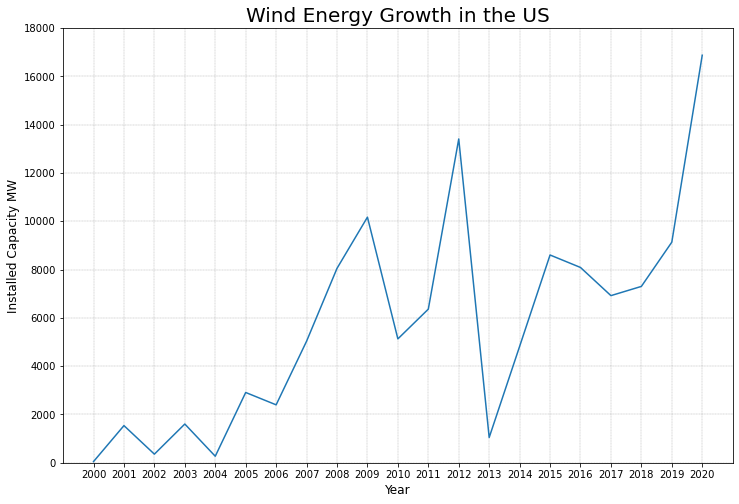

In [13]:
WF_year = modern_WF_MW.groupby('Year')
MW_year = WF_year['WF Total MW'].sum()
x = MW_year.index
y = MW_year.values
plt.subplots(figsize=(12, 8))
plt.plot(x,y)
plt.xlabel('Year',fontsize=12)
plt.ylabel('Installed Capacity MW',fontsize=12)
plt.title('Wind Energy Growth in the US',fontsize=20)
plt.ylim(0,18000)
plt.grid(color='grey', linestyle='--', linewidth=0.3)
plt.xticks(range(2000,2021))
plt.show()

# Plot wind farm installed capacity by state

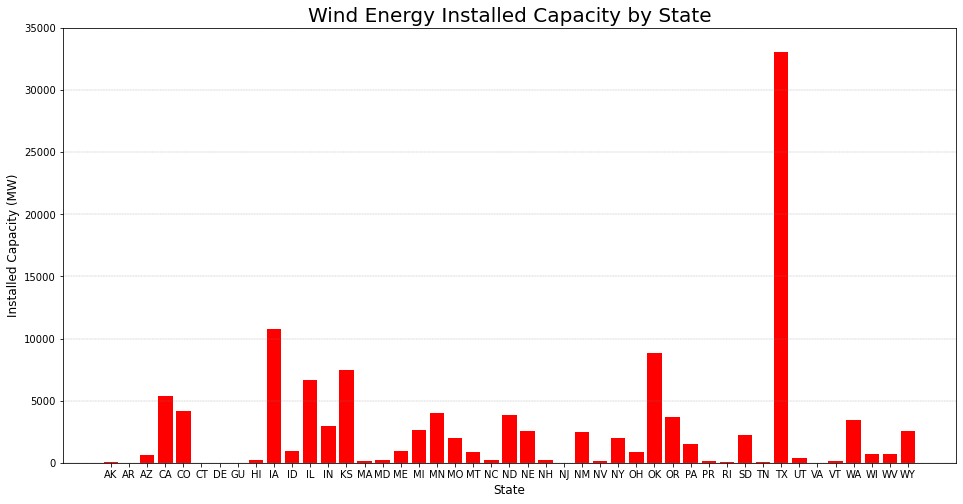

In [14]:
WF_state = modern_WF_MW.groupby('State')
WF_state_MW = WF_state['WF Total MW'].sum()
x = WF_state_MW.index
y = WF_state_MW.values
plt.subplots(figsize=(16, 8))
plt.bar(x,y,color='r')
plt.xlabel('State',fontsize=12)
plt.ylabel('Installed Capacity (MW)',fontsize=12)
plt.title('Wind Energy Installed Capacity by State',fontsize=20)
plt.ylim(0,35000)
plt.grid(axis='y',color='grey', linestyle='--', linewidth=0.3)
plt.show()

In [15]:
coords = []
cities = []
       
#Generate a random list of 500+ cities
lat = modern_WF_MW['lat']
lng = modern_WF_MW['lng']
coords = list(zip(lat,lng))

for coord in coords:
    cityname = citipy.nearest_city(float(coord[0]), float(coord[1])).city_name
    cities.append(cityname)

In [16]:
modern_WF_MW = modern_WF_MW.drop(columns=['Duplicated'])
modern_WF_MW['City'] = cities

# Average turbine height trends

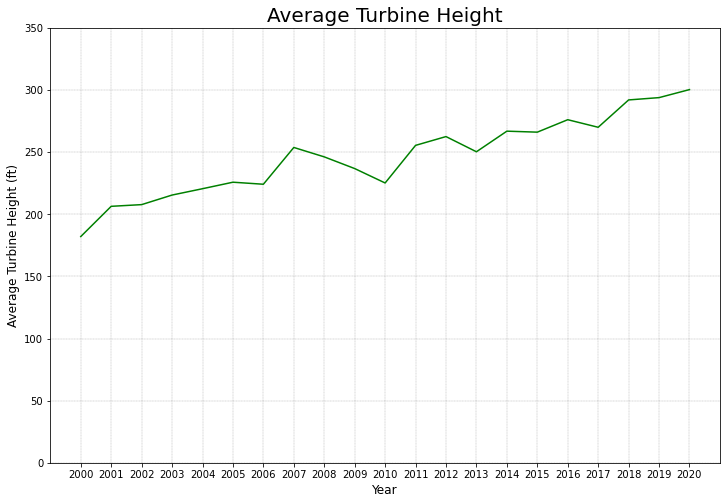

In [17]:
height_year = modern_WF_MW.groupby('Year')
height_year = (height_year['Turbine Hub Height'].mean()) * 3.28084
x = height_year.index
y = height_year.values
plt.subplots(figsize=(12, 8))
plt.plot(x,y,color='g')
plt.xlabel('Year',fontsize=12)
plt.ylabel('Average Turbine Height (ft)',fontsize=12)
plt.title('Average Turbine Height',fontsize=20)
plt.ylim(0,350)
plt.grid(color='grey', linestyle='--', linewidth=0.3)
plt.xticks(range(2000,2021))
plt.show()

# Average rotor diameter trends

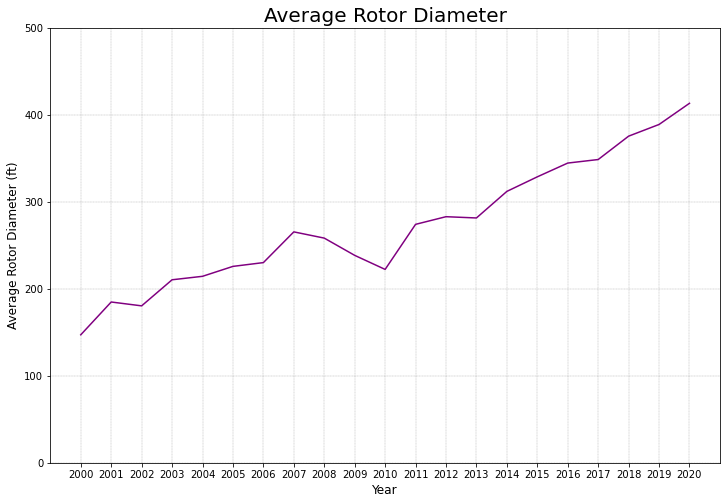

In [18]:
diameter_year = modern_WF_MW.groupby('Year')
diameter_year = (diameter_year['Rotor Diameter'].mean()) * 3.28084
x = diameter_year.index
y = diameter_year.values
plt.subplots(figsize=(12, 8))
plt.plot(x,y,color='purple')
plt.xlabel('Year',fontsize=12)
plt.ylabel('Average Rotor Diameter (ft)',fontsize=12)
plt.title('Average Rotor Diameter',fontsize=20)
plt.ylim(0,500)
plt.grid(color='grey', linestyle='--', linewidth=0.3)
plt.xticks(range(2000,2021))
plt.show()

In [19]:
state_county = modern_WF_MW.groupby(['State','County'])
county_MW = state_county['WF Total MW'].sum()


county_max_MW= county_MW.idxmax()
max_MW = county_MW.max()

print(f'{county_max_MW[1]} in {county_max_MW[0]} is the county with the maximum installed MW in the country, with a total of {max_MW} MW.' )

Kern County in CA is the county with the maximum installed MW in the country, with a total of 3084.4 MW.


# Iowa Plots

In [20]:
iowa_df = modern_WF_MW.loc[modern_WF_MW['State']=='IA']

In [21]:
# running some simple stats on energy output
iowa_df["WF Total MW"].describe()

count    140.000000
mean      77.173357
std       89.923129
min        0.100000
25%        1.790000
50%       43.000000
75%      140.190000
max      495.010000
Name: WF Total MW, dtype: float64

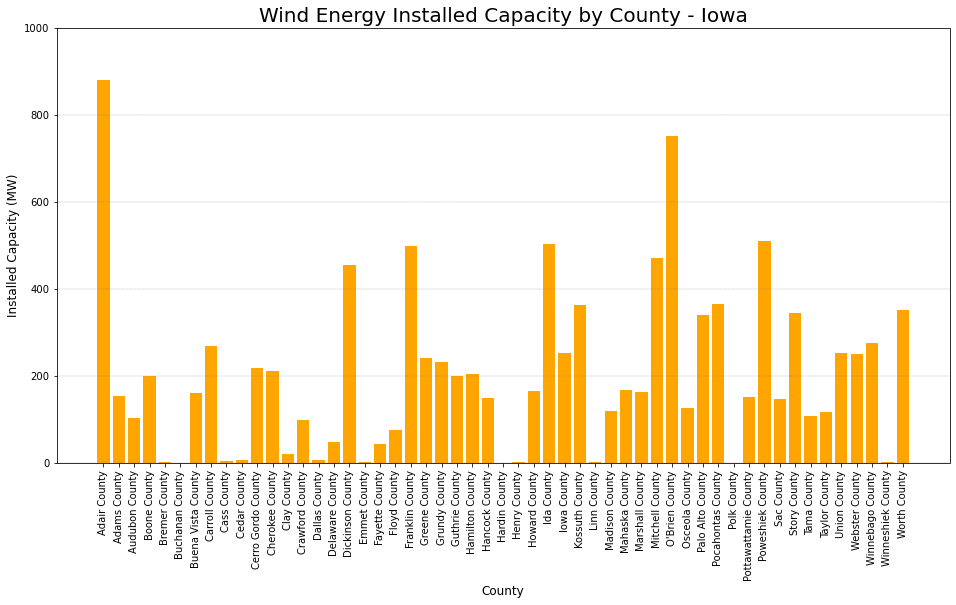

In [22]:
WF_IA = iowa_df.groupby('County')
WF_county_IA = WF_IA['WF Total MW'].sum()
x = WF_county_IA.index
y = WF_county_IA.values
plt.subplots(figsize=(16, 8))
plt.bar(x,y,color='orange')
plt.xlabel('County',fontsize=12)
plt.ylabel('Installed Capacity (MW)',fontsize=12)
plt.title('Wind Energy Installed Capacity by County - Iowa',fontsize=20)
plt.ylim(0,1000)
plt.xticks(rotation = 90)
plt.grid(axis='y',color='grey', linestyle='--', linewidth=0.3)
plt.show()

# Oklahoma Plots

In [23]:
oklahoma_df = modern_WF_MW.loc[modern_WF_MW['State']=='OK']

In [24]:
oklahoma_df["WF Total MW"].describe()

count     61.000000
mean     145.494590
std       78.290797
min        0.100000
25%       99.000000
50%      129.880000
75%      198.900000
max      310.640000
Name: WF Total MW, dtype: float64

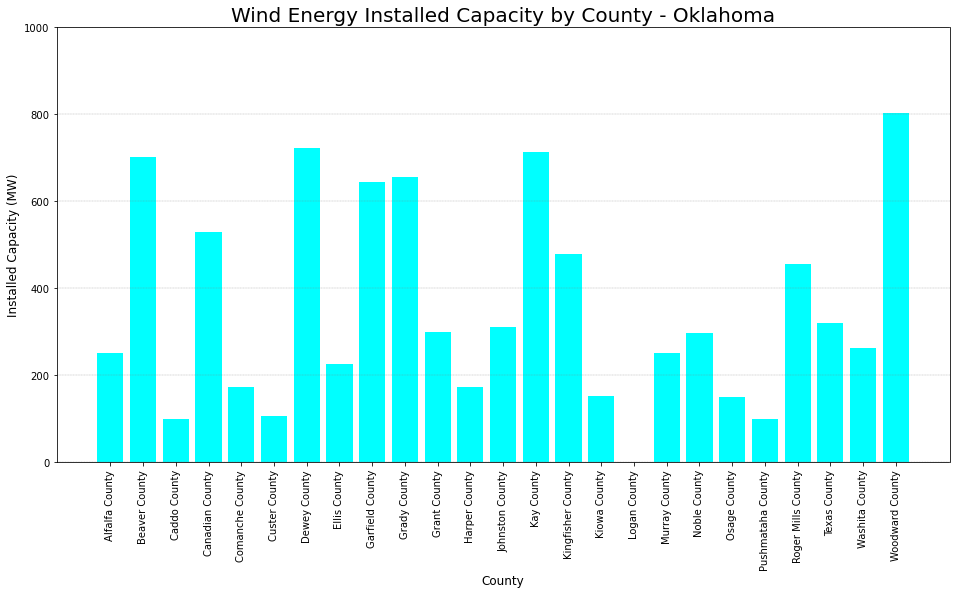

In [25]:
WF_OK = oklahoma_df.groupby('County')
WF_county_OK = WF_OK['WF Total MW'].sum()
x = WF_county_OK.index
y = WF_county_OK.values
plt.subplots(figsize=(16, 8))
plt.bar(x,y,color='cyan')
plt.xlabel('County',fontsize=12)
plt.ylabel('Installed Capacity (MW)',fontsize=12)
plt.title('Wind Energy Installed Capacity by County - Oklahoma',fontsize=20)
plt.ylim(0,1000)
plt.xticks(rotation = 90)
plt.grid(axis='y',color='grey', linestyle='--', linewidth=0.3)
plt.show()

# Oregon plots

In [26]:
oregon_df = modern_WF_MW.loc[modern_WF_MW['State']=='OR']

In [27]:
oregon_df["WF Total MW"].describe()

count     41.000000
mean      88.936585
std       85.267276
min        0.250000
25%       10.000000
50%       75.000000
75%      102.900000
max      299.540000
Name: WF Total MW, dtype: float64

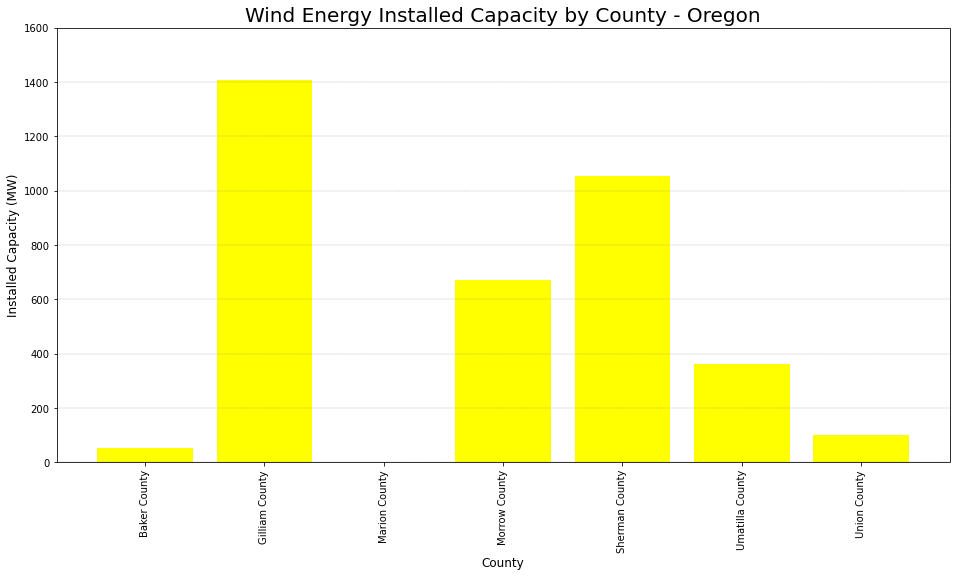

In [28]:
WF_OR = oregon_df.groupby('County')
WF_county_OR = WF_OR["WF Total MW"].sum()
x = WF_county_OR.index
y = WF_county_OR.values
plt.subplots(figsize=(16, 8))
plt.bar(x,y,color = 'yellow')
plt.xlabel('County',fontsize=12)
plt.ylabel('Installed Capacity (MW)',fontsize=12)
plt.title('Wind Energy Installed Capacity by County - Oregon',fontsize=20)
plt.ylim(0,1600)
plt.xticks(rotation = 90)
plt.grid(axis='y',color='grey', linestyle='--', linewidth=0.3)
plt.show()

# California Plots

In [29]:
calif_df = modern_WF_MW.loc[modern_WF_MW['State']=='CA']

In [30]:
calif_df["WF Total MW"].describe()

count     90.000000
mean      59.569000
std       61.421324
min        0.230000
25%        3.000000
50%       37.400000
75%      102.500000
max      222.780000
Name: WF Total MW, dtype: float64

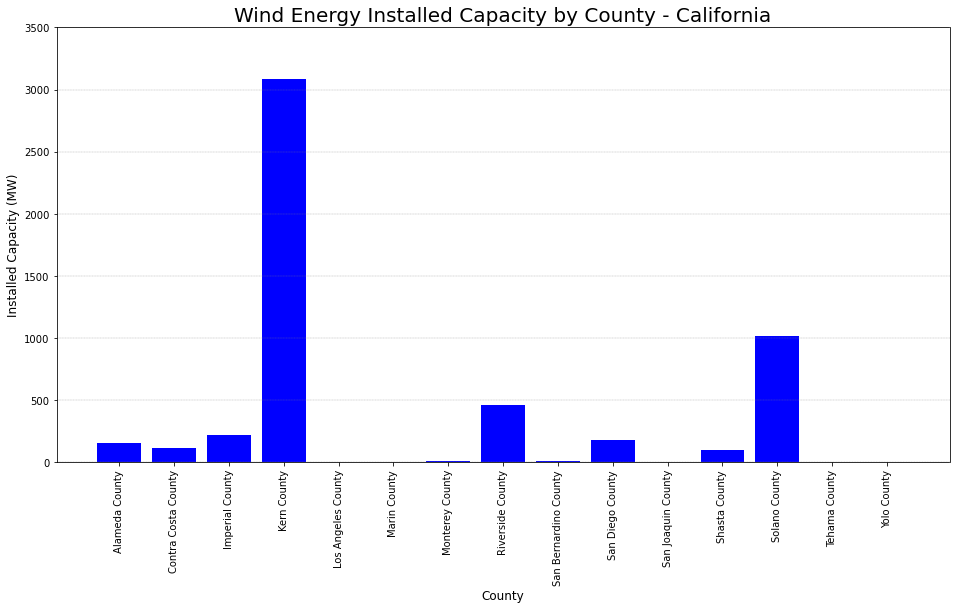

In [31]:
WF_CA = calif_df.groupby('County')
WF_county_CA = WF_CA["WF Total MW"].sum()
x = WF_county_CA.index
y = WF_county_CA.values
plt.subplots(figsize=(16, 8))
plt.bar(x,y,color = 'blue')
plt.xlabel('County',fontsize=12)
plt.ylabel('Installed Capacity (MW)',fontsize=12)
plt.title('Wind Energy Installed Capacity by County - California',fontsize=20)
plt.ylim(0,3500)
plt.xticks(rotation = 90)
plt.grid(axis='y',color='grey', linestyle='--', linewidth=0.3)
plt.show()

# Texas plot

In [32]:
texas_df = modern_WF_MW.loc[modern_WF_MW['State']=='TX']

In [33]:
texas_df["WF Total MW"].describe()

count    219.000000
mean     150.996849
std       99.002419
min        0.100000
25%       80.230000
50%      150.000000
75%      201.600000
max      525.020000
Name: WF Total MW, dtype: float64

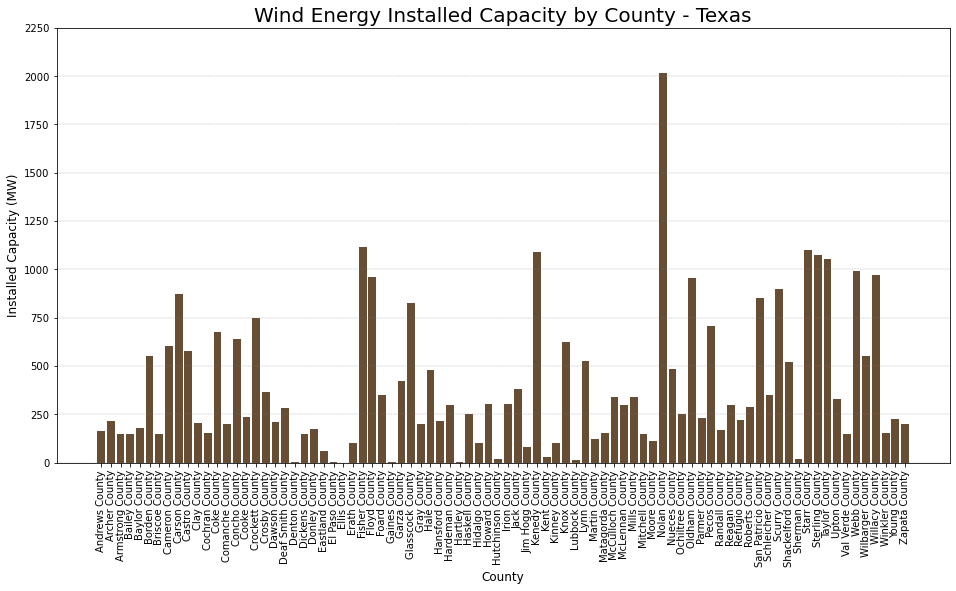

In [34]:
WF_TX = texas_df.groupby('County')
WF_county_TX = WF_TX["WF Total MW"].sum()
x = WF_county_TX.index
y = WF_county_TX.values
plt.subplots(figsize=(16, 8))
plt.bar(x,y,color = (0.4, 0.3, 0.2))
plt.xlabel('County',fontsize=12)
plt.ylabel('Installed Capacity (MW)',fontsize=12)
plt.title('Wind Energy Installed Capacity by County - Texas',fontsize=20)
plt.ylim(0,2250)
plt.xticks(rotation = 90)
plt.grid(axis='y',color='grey', linestyle='--', linewidth=0.3)
plt.show()

In [35]:
base_url = 'http://api.eia.gov/series/?'

In [52]:
# creates empty series
coal_prod = []
oil_prod = []
geothermal_prod = []
hydropower_prod = []
naturalgasdry_prod = []
naturalgasliquid_prod = []
nuclear_prod = []
solar_prod = []
biomass_prod = []
wind_prod = []
fossilfuel_prod = []
renewable_prod = []
coal_x = []
coal_y = []
oil_x = []
oil_y = []
geothermal_x =[]
geothermal_y =[]
hydropower_x =[]
hydropower_y =[]
naturalgasdry_x =[]
naturalgasdry_y =[]
naturalgasliquid_x =[]
naturalgasliquid_y =[]
nuclear_x =[]
nuclear_y =[]
solar_x =[]
solar_y =[]
biomass_x =[]
biomass_y =[]
wind_x =[]
wind_y =[]
fossilfuel_x =[]
fossilfuel_y =[]
renewable_x = []
renewable_y = []
CO2total_x = []
CO2total_y = []
CO2total = []

# US Enenery Information Administration (EIA) API

# Get energy production generated by coal in the USA
series_name = 'TOTAL.CLPRBUS.A;'
query_url = base_url + 'api_key=' + EIA_api_key + '&series_id='+series_name
coal_response = requests.get(query_url).json()
coal_prod.append(coal_response['series'][0]['data'])
coal_prod = coal_prod[0]
for i in reversed (coal_prod):
    coal_x.append(i[0])
    coal_y.append(i[1])

# Get energy production generated by oil in the USA
series_name = 'TOTAL.PAPRBUS.A'
query_url = base_url + 'api_key=' + EIA_api_key + '&series_id='+series_name
oil_response = requests.get(query_url).json()
oil_prod.append(oil_response['series'][0]['data'])
oil_prod = oil_prod[0]
for i in reversed (oil_prod):
    oil_x.append(i[0]) 
    oil_y.append(i[1])

# Get energy production generated by geothermal in the USA
series_name = 'TOTAL.GETCBUS.A'
query_url = base_url + 'api_key=' + EIA_api_key + '&series_id='+series_name
geothermal_response = requests.get(query_url).json()
geothermal_prod.append(geothermal_response['series'][0]['data'])
geothermal_prod = geothermal_prod[0]
for i in reversed (geothermal_prod):
    geothermal_x.append(i[0]) 
    geothermal_y.append(i[1])

# Get energy production generated by hydro in the USA
series_name = 'TOTAL.HVTCBUS.A'
query_url = base_url + 'api_key=' + EIA_api_key + '&series_id='+series_name
hydropower_response = requests.get(query_url).json()
hydropower_prod.append(hydropower_response['series'][0]['data'])
hydropower_prod = hydropower_prod[0]
for i in reversed (hydropower_prod):
    hydropower_x.append(i[0]) 
    hydropower_y.append(i[1])

# Get energy production generated by dry natural gas in the USA
series_name = 'TOTAL.NGPRBUS.A'
query_url = base_url + 'api_key=' + EIA_api_key + '&series_id='+series_name
naturalgasdry_response = requests.get(query_url).json()
naturalgasdry_prod.append(naturalgasdry_response['series'][0]['data'])
naturalgasdry_prod = naturalgasdry_prod[0]
for i in reversed (naturalgasdry_prod):
    naturalgasdry_x.append(i[0]) 
    naturalgasdry_y.append(i[1])

# Get energy production generated by liquid natural gas in the USA
series_name = 'TOTAL.NLPRBUS.A'
query_url = base_url + 'api_key=' + EIA_api_key + '&series_id='+series_name
naturalgasliquid_response = requests.get(query_url).json()
naturalgasliquid_prod.append(naturalgasliquid_response['series'][0]['data'])
naturalgasliquid_prod = naturalgasliquid_prod[0]
for i in reversed (naturalgasliquid_prod):
    naturalgasliquid_x.append(i[0]) 
    naturalgasliquid_y.append(i[1])

# Get energy production generated by nuclear in the USA
series_name = 'TOTAL.NUETBUS.A'
query_url = base_url + 'api_key=' + EIA_api_key + '&series_id='+series_name
nuclear_response = requests.get(query_url).json()
nuclear_prod.append(nuclear_response['series'][0]['data'])
nuclear_prod = nuclear_prod[0]
for i in reversed (nuclear_prod):
    nuclear_x.append(i[0]) 
    nuclear_y.append(i[1])

# Get energy production generated by solar in the USA
series_name = 'TOTAL.SOTCBUS.A'
query_url = base_url + 'api_key=' + EIA_api_key + '&series_id='+series_name
solar_response = requests.get(query_url).json()
solar_prod.append(solar_response['series'][0]['data'])
solar_prod = solar_prod[0]
for i in reversed (solar_prod):
    solar_x.append(i[0]) 
    solar_y.append(i[1])
    
# Get energy production generated by biomass in the USA
series_name = 'TOTAL.BMPRBUS.A'
query_url = base_url + 'api_key=' + EIA_api_key + '&series_id='+series_name
biomass_response = requests.get(query_url).json()
biomass_prod.append(biomass_response['series'][0]['data'])
biomass_prod = biomass_prod[0]
for i in reversed (biomass_prod):
    biomass_x.append(i[0]) 
    biomass_y.append(i[1])

# Get energy production generated by wind in the USA
series_name = 'TOTAL.WYTCBUS.A'
query_url = base_url + 'api_key=' + EIA_api_key + '&series_id='+series_name
wind_response = requests.get(query_url).json()
wind_prod.append(wind_response['series'][0]['data'])
wind_prod = wind_prod[0]
for i in reversed (wind_prod):
    wind_x.append(i[0]) 
    wind_y.append(i[1])
    
# Get energy production generated by all fossil sources in the USA
series_name = 'TOTAL.FFPRBUS.A'
query_url = base_url + 'api_key=' + EIA_api_key + '&series_id='+series_name
fossilfuel_response = requests.get(query_url).json()
fossilfuel_prod.append(fossilfuel_response['series'][0]['data'])
fossilfuel_prod = fossilfuel_prod[0]
for i in reversed (fossilfuel_prod):
    fossilfuel_x.append(i[0]) 
    fossilfuel_y.append(i[1])

# Get energy production generated by all renewable sources in the USA
series_name = 'TOTAL.REPRBUS.A'
query_url = base_url + 'api_key=' + EIA_api_key + '&series_id='+series_name
renewable_response = requests.get(query_url).json()
renewable_prod.append(renewable_response['series'][0]['data'])
renewable_prod = renewable_prod[0]
for i in reversed (renewable_prod):
    renewable_x.append(i[0]) 
    renewable_y.append(i[1])

# Get CO2 emission in the USA

series_name = 'STEO.TETCCO2.A'
query_url = base_url + 'api_key=' + EIA_api_key + '&series_id='+series_name
CO2_response = requests.get(query_url).json()
CO2total.append(CO2_response['series'][0]['data'])
CO2total = CO2total[0]
for i in reversed (CO2total):
    CO2total_x.append(i[0]) 
    CO2total_y.append(i[1])


# Add sources to dataframe
coal_source = pd.DataFrame(coal_x)
coal_source.set_axis(['Year'], axis='columns', inplace=True)
coal_source['Coal'] = coal_y

oil_source = pd.DataFrame(oil_x)
oil_source.set_axis(['Year'], axis='columns', inplace=True)
oil_source['Oil'] = oil_y

source_df = pd.merge(coal_source,oil_source,on="Year", how="outer")

geothermal_source = pd.DataFrame(geothermal_x)
geothermal_source.set_axis(['Year'], axis='columns', inplace=True)
geothermal_source['Geothermal'] = geothermal_y
source_df = pd.merge(source_df,geothermal_source,on="Year", how="outer")

wind_source = pd.DataFrame(wind_x)
wind_source.set_axis(['Year'], axis='columns', inplace=True)
wind_source['Wind'] = wind_y
source_df = pd.merge(source_df,wind_source,on="Year", how="outer")

hydropower_source = pd.DataFrame(hydropower_x)
hydropower_source.set_axis(['Year'], axis='columns', inplace=True)
hydropower_source['Hydropower'] = hydropower_y
source_df = pd.merge(source_df,hydropower_source,on="Year", how="outer")

naturalgasdry_source = pd.DataFrame(naturalgasdry_x)
naturalgasdry_source.set_axis(['Year'], axis='columns', inplace=True)
naturalgasdry_source['Natural Gas Dry'] = naturalgasdry_y
source_df = pd.merge(source_df,naturalgasdry_source,on="Year", how="outer")

naturalgasliquid_source = pd.DataFrame(naturalgasliquid_x)
naturalgasliquid_source.set_axis(['Year'], axis='columns', inplace=True)
naturalgasliquid_source['Natural Gas Liquid'] = naturalgasliquid_y
source_df = pd.merge(source_df,naturalgasliquid_source,on="Year", how="outer")

nuclear_source = pd.DataFrame(nuclear_x)
nuclear_source.set_axis(['Year'], axis='columns', inplace=True)
nuclear_source['Nuclear'] = nuclear_y
source_df = pd.merge(source_df,nuclear_source,on="Year", how="outer")

solar_source = pd.DataFrame(solar_x)
solar_source.set_axis(['Year'], axis='columns', inplace=True)
solar_source['Solar'] = solar_y
source_df = pd.merge(source_df,solar_source,on="Year", how="outer")

biomass_source = pd.DataFrame(biomass_x)
biomass_source.set_axis(['Year'], axis='columns', inplace=True)
biomass_source['Biomass'] = biomass_y
source_df = pd.merge(source_df,biomass_source,on="Year", how="outer")

# Add source categories to dataframe
fossilfuel_source = pd.DataFrame(fossilfuel_x)
fossilfuel_source.set_axis(['Year'], axis='columns', inplace=True)
fossilfuel_source['Fossil Fuel'] = fossilfuel_y

main_sources = pd.DataFrame(renewable_x)
main_sources.set_axis(['Year'], axis='columns', inplace=True)
main_sources['Renewable'] = renewable_y

main_sources = pd.merge(main_sources,nuclear_source,on="Year", how="outer")
main_sources = pd.merge(main_sources,fossilfuel_source,on="Year", how="outer")


#CO2 data frame
CO2_df = pd.DataFrame(CO2total_x)
CO2_df.set_axis(['Year'], axis='columns', inplace=True)
CO2_df['CO2 Total'] = CO2total_y

source_df['Year'] = source_df['Year'].astype(int)
main_sources['Year'] = main_sources['Year'].astype(int)
CO2_df['Year'] = CO2_df['Year'].astype(int)
source = source_df.loc[source_df['Year'] >= 2000,:]
main_sources = main_sources.loc[main_sources['Year'] >= 2000,:]
CO2_df = CO2_df.loc[(CO2_df['Year'] >= 2000) & (CO2_df['Year'] < 2021),:]

CO2_df

,Year,CO2 Total
10,2000,5861.952305
11,2001,5760.365764
12,2002,5801.794243
13,2003,5851.849982
14,2004,5971.305802
15,2005,5991.352987
16,2006,5910.781068
17,2007,6001.147864
18,2008,5817.342250
19,2009,5392.702818


# Plots

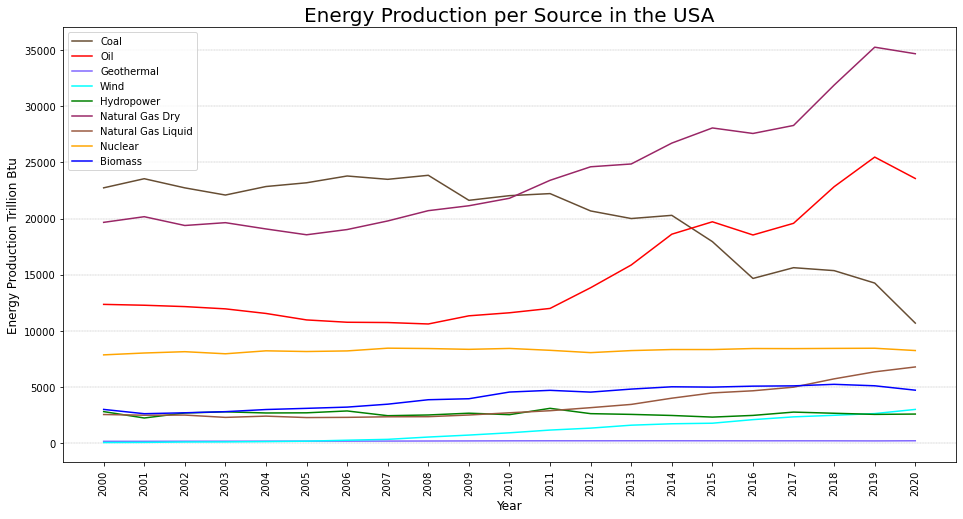

No handles with labels found to put in legend.


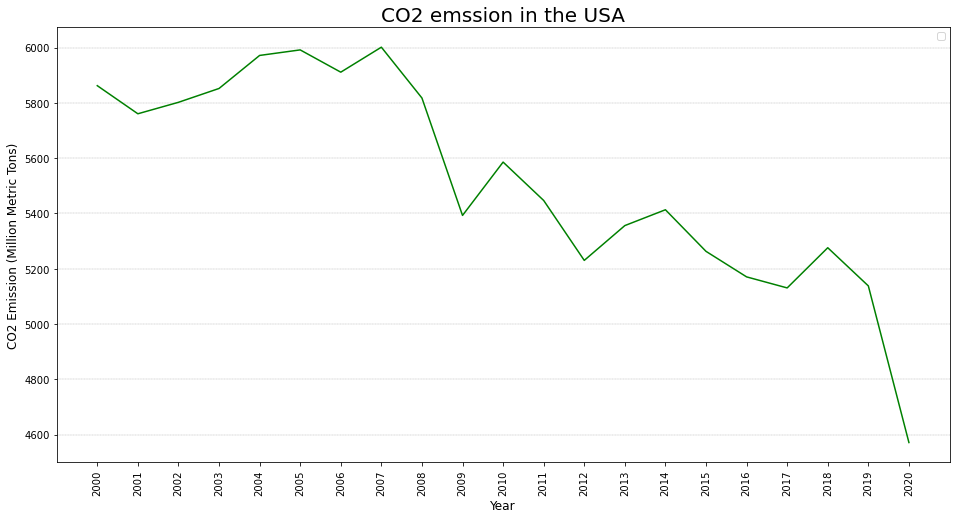

In [61]:
year = source['Year']
plt.subplots(figsize=(16, 8))
coal_handle, = plt.plot(year, source['Coal'], color=(0.4, 0.3, 0.2), label="Coal")
oil_handle, = plt.plot(year, source['Oil'], color='red', label="Oil")
geothermal_handle, = plt.plot(year, source['Geothermal'], color=(0.5, 0.4, 1.0), label="Geothermal")
wind_handle, = plt.plot(year, source['Wind'], color='cyan', label="Wind")
hydropower_handle, = plt.plot(year, source['Hydropower'], color='green', label="Hydropower")
naturalgasdry_handle, = plt.plot(year, source['Natural Gas Dry'], color=(0.6, 0.15, 0.4), label="Natural Gas Dry")
naturalgasliquid_handle, = plt.plot(year, source['Natural Gas Liquid'], color=(0.6, 0.35, 0.25), label="Natural Gas Liquid")
nuclear_handle, = plt.plot(year, source['Nuclear'], color='orange', label="Nuclear")
biomass_handle, = plt.plot(year, source['Biomass'], color='blue', label="Biomass")
plt.xticks(range(2000,2021))
plt.grid(axis='y',color='grey', linestyle='--', linewidth=0.3)
plt.xlabel('Year',fontsize=12)
plt.ylabel('Energy Production Trillion Btu',fontsize=12)
plt.title('Energy Production per Source in the USA',fontsize=20)
plt.legend(loc="best")

plt.xticks(rotation = 90)
plt.show()



co2 = CO2_df['CO2 Total']
year = source['Year']
plt.subplots(figsize=(16, 8))
plt.plot(year, co2, color='green')
plt.xticks(range(2000,2021))
plt.grid(axis='y',color='grey', linestyle='--', linewidth=0.3)
plt.xlabel('Year',fontsize=12)
plt.ylabel('CO2 Emission (Million Metric Tons)',fontsize=12)
plt.title('CO2 emssion in the USA',fontsize=20)
plt.legend(loc="best")

plt.xticks(rotation = 90)
plt.show()

# Pie chart with production by source (nuclear, fossil fuel and renewables) 

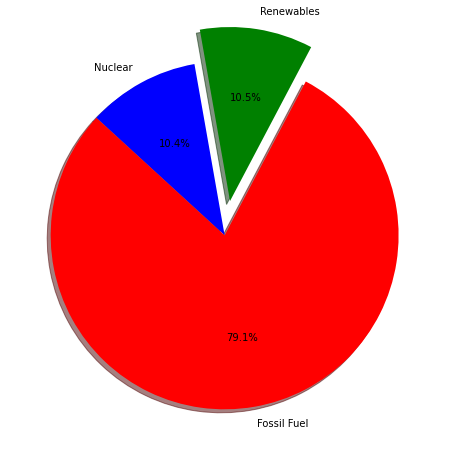

In [54]:
# Labels for the sections of our pie chart
labels = ["Nuclear", "Fossil Fuel", "Renewables"]

nuclear = main_sources['Nuclear'].sum()
fossil_fuel = main_sources['Fossil Fuel'].sum()
renewable = main_sources['Renewable'].sum()

# The values of each section of the pie chart
sizes = [nuclear, fossil_fuel, renewable]

# The colors of each section of the pie chart
colors = ["blue", "red", "green"]

# Tells matplotlib to seperate the "Humans" section from the others
explode = (0, 0, 0.2)
plt.subplots(figsize=(16, 8))
# Creates the pie chart based upon the values above
# Automatically finds the percentages of each part of the pie chart
plt.pie(sizes,explode=explode,  labels=labels, colors=colors,
        autopct="%1.1f%%", shadow=True, startangle=100)

plt.show()

# Correlation fossil fuel x renewable

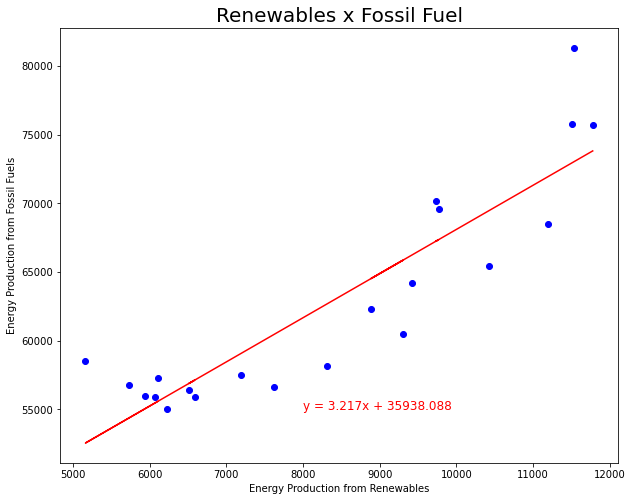

The r-squared is: 0.8019


In [69]:
# Calculate the correlation coefficient and linear regression model 
# for 
regress_values=[]
renewable = main_sources['Renewable']
fossil =  main_sources['Fossil Fuel']


plt.subplots(figsize=(10, 8))
(slope, intercept, rvalue, pvalue, stderr) = linregress(renewable, fossil)
regress_values = np.asarray(renewable) * slope + intercept
line_eq = "y = " + str(round(slope,3)) + "x + " + str(round(intercept,3))
plt.scatter(renewable, fossil,  color = 'blue')
plt.plot(renewable,regress_values,"r-")

plt.annotate(line_eq,(8000, 55000),fontsize=12,color="red")
plt.xlabel('Energy Production from Renewables')
plt.ylabel('Energy Production from Fossil Fuels')
plt.title('Renewables x Fossil Fuel',fontsize=20)
plt.show()
print(f"The r-squared is: {round(rvalue**2,4)}")

